In [1]:
import itertools
import gzip

import pandas
import rdkit.Chem
import rdkit.Chem.AllChem
import rdkit.DataStructs

In [4]:
# 따로 Download 받은 파일로 진행 ---
# Download DrugBank SDF file of structures
# ! wget --timestamping --directory-prefix download http://www.drugbank.ca/system/downloads/current/structures/all.sdf.zip
# ! unzip -d download download/all.sdf.zip
# ! rm download/all.sdf.zip

--2015-05-18 14:03:23--  http://www.drugbank.ca/system/downloads/current/structures/all.sdf.zip
Resolving www.drugbank.ca (www.drugbank.ca)... 162.243.242.197
Connecting to www.drugbank.ca (www.drugbank.ca)|162.243.242.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4362948 (4.2M) [application/zip]
Server file no newer than local file ‘download/all.sdf.zip’ -- not retrieving.

Archive:  download/all.sdf.zip
  inflating: download/all.sdf        


In [5]:
# Read SDF File
# supplier = rdkit.Chem.SDMolSupplier('download/all.sdf')

# Read approved structures SDF Format
approved_supplier = rdkit.Chem.SDMolSupplier('download/approved_structures.sdf')

approved_molecules = [mol for mol in approved_supplier if mol is not None]
print('approved drug: ' + str(len(approved_molecules)))
      
      
# Read all structures SDF File
all_supplier = rdkit.Chem.SDMolSupplier('download/all_structures.sdf')
all_molecules = [mol for mol in all_supplier if mol is not None]
print('all drug: ' + str(len(all_molecules))    )

approved drug: 2507
all drug: 11159


In [6]:
# Calculate fingerprints
fingerprints = dict()
for mol in approved_molecules:
    drugbank_id = mol.GetProp('DATABASE_ID')
    fingerprint = rdkit.Chem.AllChem.GetMorganFingerprint(mol, 2)
    fingerprints[drugbank_id] = fingerprint

In [7]:
# Calculate pairwise compound similarities
similarity_rows = list()
for (id0, fp0), (id1, fp1) in itertools.combinations(fingerprints.items(), 2):
    similarity = rdkit.DataStructs.DiceSimilarity(fp0, fp1)
    similarity = round(similarity, 4)
    similarity_rows.append([id0, id1, similarity])

In [8]:
# Create a DataFrame of pairwise similarities
similarity_df = pandas.DataFrame(similarity_rows, columns=['compound0', 'compound1', 'similarity'])

# with gzip.open('data/similarity.tsv.gz', 'w') as write_file:
#     similarity_df.to_csv(write_file, sep='\t', index=False)
    
# write a pandas dataframe to gzipped CSV file
similarity_df.to_csv("data/similarity.tsv.gz", 
           index=False, 
           compression="gzip")

similarity_df.head()

,compound0,compound1,similarity
0,DB00006,DB00007,0.5526
1,DB00006,DB00014,0.5178
2,DB00006,DB00027,0.4796
3,DB00006,DB00035,0.3911
4,DB00006,DB00050,0.5969


In [9]:
# Save a similarity tsv with only compounds in our slim drugbank set
#drugbank_slim_df = pandas.read_table('data/drugbank-slim.tsv')
# 새로운 slim.tsv / 2021 year version
drugbank_slim_df = pandas.read_table('D:/WorkSpace/master_thesis/Drug_Bank/result/drugbank-slim.tsv')
slim_ids = set(drugbank_slim_df.drugbank_id)

similarity_slim_df = similarity_df[similarity_df.compound0.isin(slim_ids) & similarity_df.compound1.isin(slim_ids)]

# with gzip.open('data/similarity-slim.tsv.gz', 'w') as write_file:
#     similarity_slim_df.to_csv(write_file, sep='\t', index=False)

# write a pandas dataframe to gzipped CSV file
similarity_slim_df.to_csv("data/similarity-slim.tsv.gz", 
           index=False, 
           compression="gzip")

float(len(similarity_slim_df)) / len(similarity_df)

1.0

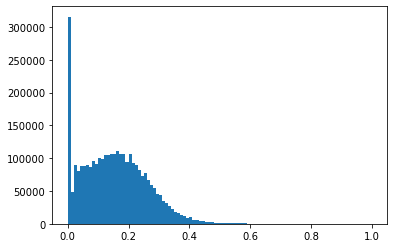

In [10]:
# histogram of similarities
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(similarity_df.similarity, 100);

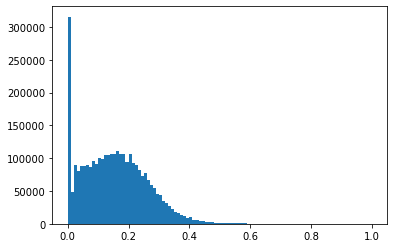

In [11]:
# histogram of similarities in slim subset
plt.hist(list(similarity_slim_df.similarity), 100);